https://github.com/booz-allen-hamilton/DSB3Tutorial/blob/master/Tutorial.ipynb

https://pyscience.wordpress.com/2014/11/02/multi-modal-image-segmentation-with-python-simpleitk/

In [2]:
from __future__ import print_function, division
import SimpleITK as sitk
import numpy as np
import csv
from glob import glob
import pandas as pd
import os

In [1]:
try:
    from tqdm import tqdm 
except:
    print('could not load TQDM')
    tqdm = lambda x: x

#Some helper functions

def make_mask(center,diam,z,width,height,spacing,origin): # z = position in !!real world!! converted value was passed
    mask = np.zeros([height,width]) # 0's everywhere except nodule swapping x,y to match img

    # Defining the voxel range in which the nodule falls
    v_center = (center-origin)/spacing
    v_diam = int(diam/spacing[0]+5)
    v_xmin = np.max([0,int(v_center[0]-v_diam)-5]) # farthest left x coordinate in voxel space. 0 if negative
    v_xmax = np.min([width-1,int(v_center[0]+v_diam)+5]) # farthest right x coordinate, or right border if too high
    v_ymin = np.max([0,int(v_center[1]-v_diam)-5]) # same here for y coordinates
    v_ymax = np.min([height-1,int(v_center[1]+v_diam)+5])

    v_xrange = range(v_xmin,v_xmax+1)
    v_yrange = range(v_ymin,v_ymax+1)

    # Convert back to world coordinates for distance calculation
    x_data = [x*spacing[0]+origin[0] for x in range(width)] 
    y_data = [x*spacing[1]+origin[1] for x in range(height)]

    # Fill in 1s within sphere around nodule
    for v_x in v_xrange:
        for v_y in v_yrange:
            p_x = spacing[0]*v_x + origin[0]
            p_y = spacing[1]*v_y + origin[1]
            if np.linalg.norm(center-np.array([p_x,p_y,z]))<=diam: # linalg norm = max stretch after transform... check if inside diam
                mask[int((p_y-origin[1])/spacing[1]),int((p_x-origin[0])/spacing[0])] = 1.0
    return(mask)

#def matrix2int16(matrix):
#    ''' 
#matrix must be a numpy array NXN
#Returns uint16 version
#    '''
#    m_min= np.min(matrix)
#    m_max= np.max(matrix)
#    matrix = matrix-m_min
#    return(np.array(np.rint( (matrix-m_min)/float(m_max-m_min) * 65535.0),dtype=np.uint16))

# List of image files
luna_path = 'D:/Data/LUNA16/'
luna_subset_path = luna_path+"subset0/"
output_path = "D:/Data/LUNA16/output/"
file_list=glob(luna_subset_path+"*.mhd")

# For each file in the set of CTs, check if the row ID matches that file.
# If so, return the path of the case CT to put in a new column containing file paths.  
def get_filename(file_list, case):
    for f in file_list:
        if case in f:
            return(f)

# df_node is a df containing locations of the nodes and diameters. Add a new column
# containing the file paths.
df_node = pd.read_csv(luna_path+"annotations.csv")
df_node["file"] = df_node["seriesuid"].map(lambda file_name: get_filename(file_list, file_name))
df_node = df_node.dropna()

# Looping over the image files
# fcount is the counter for what file we're on. img_file is the file we're analyzing. 
for fcount, img_file in enumerate(tqdm(file_list)): 
    mini_df = df_node[df_node["file"]==img_file] # mini_df = df for nodes located in img_file CT
    if mini_df.shape[0]>0: # skip img_files with no nodules
        itk_img = sitk.ReadImage(img_file) 
        img_array = sitk.GetArrayFromImage(itk_img) 
        num_z, height, width = img_array.shape      # voxel counts in each Z, Y, X dimension (sitk reverses axes)
        origin = np.array(itk_img.GetOrigin())      # x,y,x in mm real world location? what point does this correspond to in the CT????
        spacing = np.array(itk_img.GetSpacing())    # spacing of voxels in mm

        for node_idx, cur_row in mini_df.iterrows():       
            node_x = cur_row["coordX"]
            node_y = cur_row["coordY"]
            node_z = cur_row["coordZ"]
            diam = cur_row["diameter_mm"]
            
            # keep 3 slices
            imgs = np.ndarray([3,height,width],dtype=np.float32) # the 3 slices
            masks = np.ndarray([3,height,width],dtype=np.uint8) # 
            center = np.array([node_x, node_y, node_z])   # nodule center in real space
            v_center = np.rint((center-origin)/spacing)  # nodule center in voxel space (still x,y,z ordering)
            for i, i_z in enumerate(np.arange(int(v_center[2])-1,
                             int(v_center[2])+2).clip(0, num_z-1)): # for each slice number i_z (e.g. 59, 60, 61)
                mask = make_mask(center, diam, i_z*spacing[2]+origin[2], # make a mask by calling make_mask()
                                 width, height, spacing, origin)
                masks[i] = mask
                imgs[i] = img_array[i_z]
            np.save(os.path.join(output_path,"images_%04d_%04d.npy" % (fcount, node_idx)),imgs) # pickle the imgs
            np.save(os.path.join(output_path,"masks_%04d_%04d.npy" % (fcount, node_idx)),masks) #pickle the masks


TQDM does make much nicer wait bars...


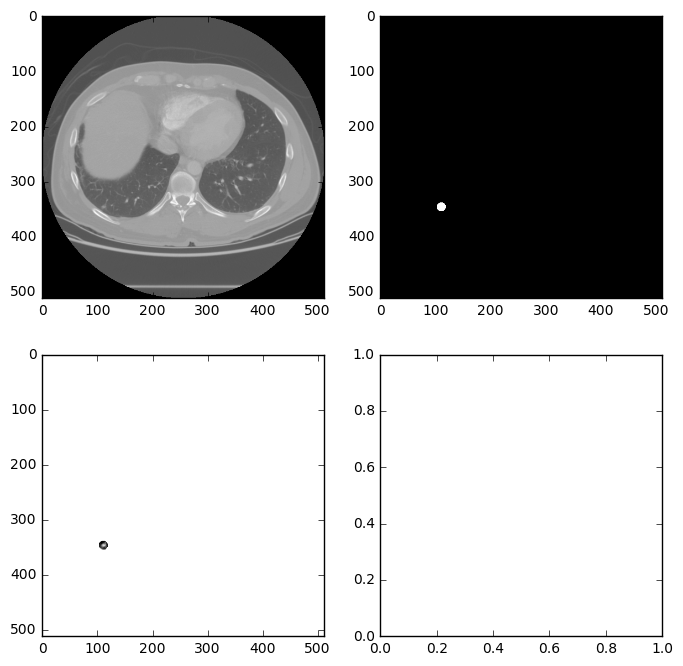

hit enter to cont : 


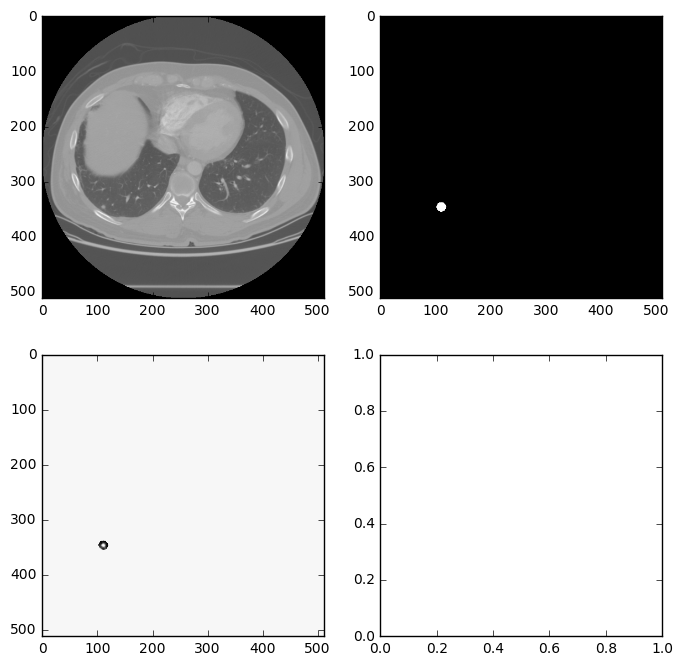

hit enter to cont : 


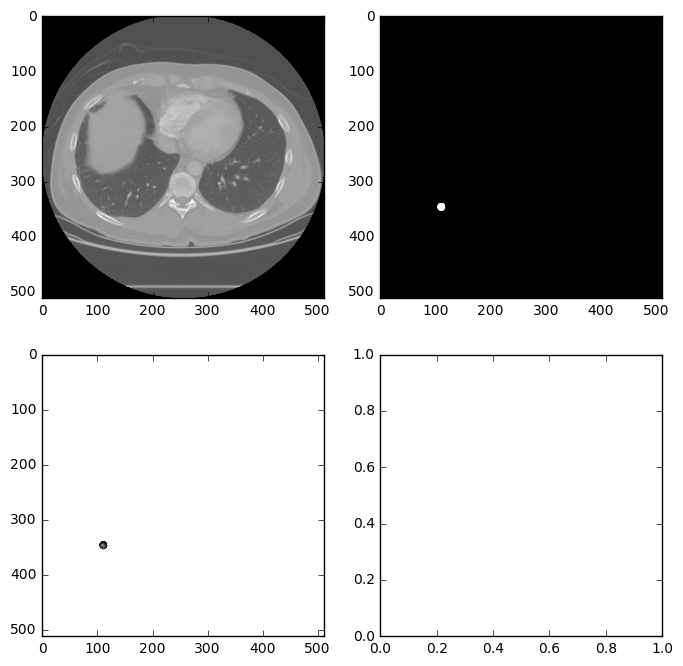

hit enter to cont : 


In [10]:
import matplotlib.pyplot as plt

output_path='D:/Data/LUNA16/output/'

imgs = np.load(output_path+'images_0001_0023.npy')
masks = np.load(output_path+'masks_0001_0023.npy')
for i in range(len(imgs)):
    #print "image %d" % i
    fig,ax = plt.subplots(2,2,figsize=[8,8])
    ax[0,0].imshow(imgs[i],cmap='gray')
    ax[0,1].imshow(masks[i],cmap='gray')
    ax[1,0].imshow(imgs[i]*masks[i],cmap='gray')
    plt.show()
    raw_input("hit enter to cont : ")

Need to make sure negative data does not coincide with positive data

What should be fed into the NN? Just the small 3 circles?